# Predicting Monthly User Churn for Waze

This is an **advanced data analytics** project aimed at developing a machine learning model to predict monthly **user churn**. Churn quantifies the number of users who have uninstalled the Waze app or stopped using it. This project uses a synthetic dataset that mirrors real-world application usage and user behavior. An effective model will help prevent churn, improve user retention, and grow Waze’s business.

An effective model can also help identify specific factors that contribute to churn and answer questions such as: 
- Who are the users most likely to churn?
- Why do users churn? 
- When do users churn?

For example, if Waze can identify a segment of users who are at high risk of churning, Waze can proactively engage these users with special offers to try and retain them. Otherwise, Waze may lose these users without knowing why. 

Ultimately, the insights generated will help Waze leadership optimize the company’s retention strategy, enhance user experience, and make data-driven decisions about product development.

This is **Part 5** (final) of the project.

## 5. Machine learning

**The purpose** of this notebook is to showcase the knowledge of tree-based models.

**The goal** of is to build and evaluate two tree-based models—Random Forest and XGBoost—to predict whether a Waze user is retained or churned.

1. What are we being asked to do? 
   > *Predict whether a customer will churn or be retained.* 

2. What are the ethical implications of the model? What are the consequences of errors?  
   - **False negative** (model predicts user will stay, but they actually churn):  
     > *Waze misses the opportunity to take proactive steps (e.g., sending surveys, push notifications) to retain at-risk users.*
   - **False positive** (model predicts user will churn, but they actually stay):  
     > *Waze may unnecessarily target loyal users with retention campaigns, potentially creating annoyance or a negative user experience.* 

3. Do the benefits outweigh the problems?
   > *The proactive measueres taken by Waze might have unintended effects on users, and these effects might encourage user churn. Follow-up analysis on the effectiveness of the measures is recommended. If the measures are reasonable and effective, then the benefits will most likely outweigh the problems.*

4. Should we proceed with building this model? Why or why not?
   > *Yes. The risks are manageable, and the potential benefits of improved user retention make the model worthwhile.*  

### 5a. Imports and data loading

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Load dataset into dataframe
df = pd.read_csv('waze_dataset.csv')

### 5b. Data preprocessing

In [3]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


Remove the `ID` column since based on our analysis in Part 2, we don't need this information for further modeling or evaluation.

In [4]:
df = df.drop('ID', axis=1)

In [5]:
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Reminder that the dataset exhibits **class imbalance**, consisting of ≈82% retained users and ≈18% churned users.

#### Impute outliers

We know from EDA in previous parts that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

#### Feature engineering

We will recreate the same features we did in Part 4.

To reiterate, many of these engineered features are derived directly from insights identified during the EDA conducted in previous parts of the project.

##### **`km_per_driving_day`**

Mean distance driven per driving day in the last month.

In [6]:
# Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [7]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

##### **`drives_per_driving_day`**

Mean number of drives in a driving day in the last month.

In [8]:
# Create `drives_per_driving_day` feature
df['drives_per_driving_day'] = df['drives'] / df['driving_days']

# Get descriptive stats
df['drives_per_driving_day'].describe()

count    1.499200e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.800000e+00
50%      4.666667e+00
75%      1.216667e+01
max               inf
Name: drives_per_driving_day, dtype: float64

In [9]:
# Convert infinite values to zero
df.loc[df['drives_per_driving_day']==np.inf, 'drives_per_driving_day'] = 0

# Confirm that it worked
df['drives_per_driving_day'].describe()

count    14992.000000
mean         9.387368
std         19.826097
min          0.000000
25%          1.250000
50%          3.666667
75%          9.000000
max        395.000000
Name: drives_per_driving_day, dtype: float64

##### **`sessions_per_day`**

Mean number of sessions per day *since onboarding*.

In [10]:
# Create `sessions_per_day` feature
df['sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

# Get descriptive stats
df['sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: sessions_per_day, dtype: float64

##### **`km_per_drive`**

Mean number of kilometers per drive made in the last month.

In [11]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']

# Get descriptive stats
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [12]:
# Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

##### **`km_per_hour`**

Mean kilometers per hour driven in the last month.

In [13]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

# Get descriptive stats
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

##### **`percent_of_drives_to_favorite`**

Percentage of total drives that were used to navigate to one of the users' favorite places.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [14]:
# Create `percent_of_drives_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

Some of the values observed in the descriptive statistics of the engineered columns above (particularly the maximum values) appear problematic and potentially invalid, with or without outlier imputation. It would be worthwhile to seek clarification from Waze on how these features are collected to better understand why such unrealistic values occur. For now, we proceed with modeling.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   label                          14299 non-null  object 
 1   sessions                       14999 non-null  int64  
 2   drives                         14999 non-null  int64  
 3   total_sessions                 14999 non-null  float64
 4   n_days_after_onboarding        14999 non-null  int64  
 5   total_navigations_fav1         14999 non-null  int64  
 6   total_navigations_fav2         14999 non-null  int64  
 7   driven_km_drives               14999 non-null  float64
 8   duration_minutes_drives        14999 non-null  float64
 9   activity_days                  14999 non-null  int64  
 10  driving_days                   14999 non-null  int64  
 11  device                         14999 non-null  object 
 12  km_per_driving_day             14999 non-null 

In [16]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

# Drop rows with missing data in `drives_per_driving_day` column
df = df.dropna(subset=['drives_per_driving_day'])

#### Encode categorical variables

In [17]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


**Note**: We do not encode `device` here since it will be excluded from the model. This is because our statistical analysis in Part 3 showed no statistically significant difference in churn rates between iPhone and Android users, indicating that device type may not be a meaningful predictor.

### 5c. Model building

To build our model, we first need to determine what variables we want to include in our model to predict our target: `label2`.

Drop the following variables and assign the results to `X`:

* `label` (this is the target)
* `label2` (this is the target)
* `device` (not meaningful predictor)

In [18]:
# Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# Isolate y variable
y = df['label2']

#### Split the data

In [19]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#### Random forest

In [20]:
# Define the pipeline: scale features -> apply SMOTE -> fit random forest
# Scaling is not needed for random forest, but it helps SMOTE since it is distance-based
# Using a Pipeline ensures scaling and SMOTE are applied inside each cross-validation (CV) fold 
# (fit only on that fold’s training split), preventing data leakage
rf_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        random_state=42
    ))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [200, 600, 1000],
    'clf__max_features': ['sqrt', 3, 5, 7],
}

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Grid search with 5-fold CV
rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring=scoring,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit='recall'
)

In [21]:
%%time
# Fit the model
rf_grid.fit(X_train, y_train)

CPU times: user 29.1 s, sys: 819 ms, total: 30 s
Wall time: 4min 11s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_features': ['sqrt', 3, 5, 7],
                         'clf__n_estimators': [200, 600, 1000]},
             refit='recall',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [22]:
# Print the results
print('Best parameters found: ', rf_grid.best_params_)

Best parameters found:  {'clf__max_features': 3, 'clf__n_estimators': 600}


In [23]:
# Helper function
def make_results(model_name: str, model_object, metric: str) -> pd.DataFrame:
    '''
    Generate a summary DataFrame of evaluation metrics for the best model.

    Args:
        model_name (str): Label for the model in the output table.
        model_object: A fitted GridSearchCV object.
        metric (str): One of {accuracy', 'precision', 'recall', 'f1'}
                      Determines which metric is used to identify the best model.

    Returns:
        pd.DataFrame: A single-row DataFrame with the accuracy, precision, recall, F1, and AUC scores
                      for the model with the best mean 'metric' score across all CV folds.
    '''
    metric_map = {
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy',
        'roc_auc': 'mean_test_roc_auc'
    }

    cv_results = pd.DataFrame(model_object.cv_results_)
    best_row = cv_results.loc[cv_results[metric_map[metric]].idxmax()]

    return pd.DataFrame([{
        'Model': model_name,
        'Accuracy': best_row.mean_test_accuracy,
        'Precision': best_row.mean_test_precision,
        'Recall': best_row.mean_test_recall,
        'F1-Score': best_row.mean_test_f1,
        'AUC': best_row.mean_test_roc_auc,
    }])


Pass the `GridSearch` object to the `make_results()` function.

In [24]:
results = make_results('RF CV', rf_grid, 'recall')
results

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,RF CV,0.768389,0.354549,0.373979,0.363689,0.714125


Aside from the accuracy, the CV metrics aren't that good. Its recall and F1-score are **worse** than those of the optimized logistic regression model in Part 4.

#### XGBoost

In [25]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [5, 7, 9, 12],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [400, 800, 1200],
    'scale_pos_weight': [4.5, 6.5]
}

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Grid search with 5-fold CV
xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scoring,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit='recall'
)

In [26]:
%%time
# Fit the model
xgb_grid.fit(X_train, y_train)

CPU times: user 15.3 s, sys: 6.76 s, total: 22 s
Wall time: 3min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_polic...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 9],
                         'min_child_weight': [5, 7, 9, 12],
                         'n_estimators': [400, 800, 1200],
                         'scale_pos_weight': [4.5, 6.5]},
             refit='recall',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [27]:
# Print the results
print('Best parameters found: ', xgb_grid.best_params_)

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 400, 'scale_pos_weight': 6.5}


In [28]:
# Add XGBoost CV results to the table
xgb_cv_results = make_results('XGB CV', xgb_grid, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0, ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,RF CV,0.768389,0.354549,0.373979,0.363689,0.714125
1,XGB CV,0.608938,0.283776,0.790834,0.417619,0.749243


**XGBoost** achieves significantly higher recall and F1-score than Random Forest in CV, making it the **champion model** to predict the test set.

### 5d. Final results and evaluation

In [29]:
# Get the best model
best_model = xgb_grid.best_estimator_

# Generate predictions on `X_test`
y_preds = best_model.predict(X_test)

#### Confusion matrix

In [30]:
cm = confusion_matrix(y_test, y_preds)

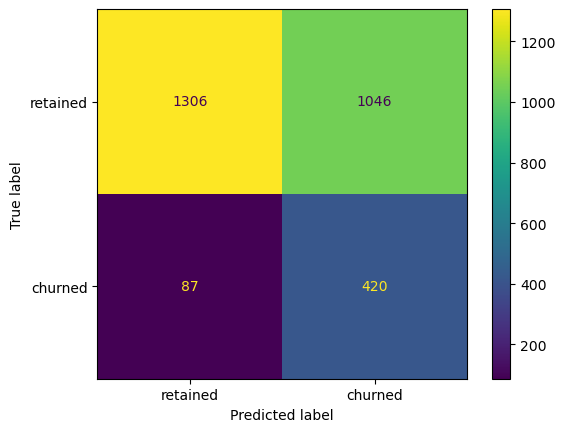

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned']
                             )
disp.plot()

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_preds)
accuracy

0.6037075900664568

In [33]:
# Calculate precision
precision = precision_score(y_test, y_preds)
precision

0.286493860845839

In [34]:
# Calculate recall
recall = recall_score(y_test, y_preds)
recall

0.8284023668639053

In [35]:
# Calculate F1-score
f1 = f1_score(y_test, y_preds)
f1

0.4257475924987329

In [36]:
# Calculate AUC
auc = roc_auc_score(y_test, y_preds)
auc

0.6918372378537214

In [37]:
# Add XGBoost test results to the table
xgb_test_results = pd.DataFrame({
    'Model': ['XGB Test'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1],
    'AUC': [auc]
})
results = pd.concat([results, xgb_test_results], axis=0, ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,RF CV,0.768389,0.354549,0.373979,0.363689,0.714125
1,XGB CV,0.608938,0.283776,0.790834,0.417619,0.749243
2,XGB Test,0.603708,0.286494,0.828402,0.425748,0.691837


XGBoost shows similar performance across validation and testing. On the test set, it achieves a recall of ≈0.83, precision of ≈0.29, and an AUC of ≈0.69. This indicates the model is highly effective at identifying churned users—capturing **over 80%** of them—while maintaining an acceptable level of discriminative ability, despite a tendency to misclassify retained users as churners.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

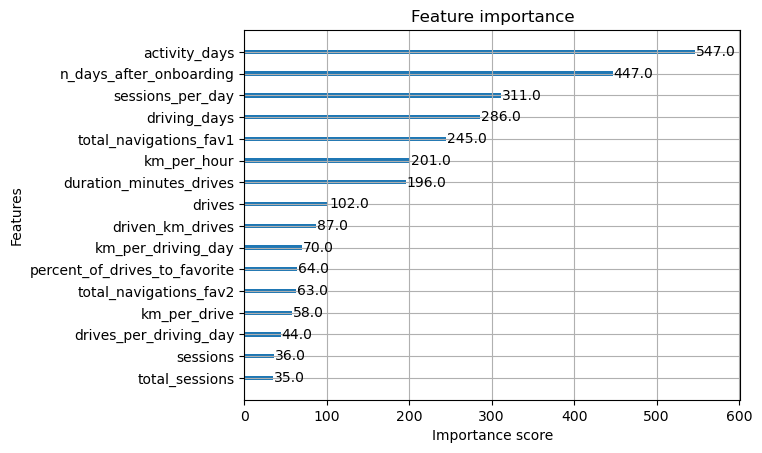

In [38]:
# Inspect the most important features of the final model
plot_importance(best_model)

The plot above shows that, similar to the logistic regression models in Part 4, `activity_days` is the most important feature in the XGBoost model.

This also highlights the importance of feature engineering. Notice that 6 out of 7 of the engineered features are used in the model. They accounted for 3 of the top 10 features (and 2 of the top 6). **EDA-driven feature engineering** is often one of the best and easiest ways to boost model performance.

That said, sometimes the data just won’t be predictive of the target, and that’s completely normal. Machine learning is powerful, but it’s not magic. If the dataset doesn’t contain predictive signal, even the most advanced model won’t be able to give reliable predictions. It’s important not to shy away from accepting this as a conclusion.

### Conclusion

1. Would we recommend using this model for churn prediction? Why or why not?

> *It depends. If the priority is predicting as many potential churners as possible—even at the cost of more false positives—the model is valuable, since its recall of ≈0.83 means it captures most churners.*

2. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like Random Forest or XGBoost) for classification tasks?

> *Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell us if each feature is positively or negatively correlated with the target in the model's final prediction.*

3. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

> *Tree-based model ensembles are often better predictors (but **not** always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with.*

4. What could we do to improve this model?

> *New features could be engineered to try to generate better predictive signal, as they often do if we have domain knowledge. In the case of this model, the engineered features accounted for 30% of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features.*

5. What additional features would we like to have to help improve the model?

> *It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs.*

# END OF PART 5